**Note**: run with GPU

# Intro Task, Object Localization 

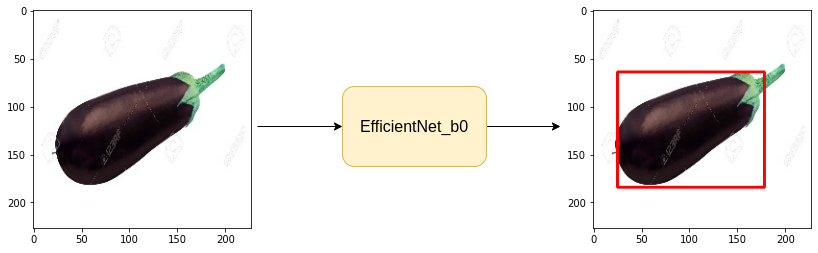

In [1]:
# install libraries/packages/modules 

!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install timm
!pip install --upgrade opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-r_q5wfmd
  Running command git clone -q https://github.com/albumentations-team/albumentations /tmp/pip-req-build-r_q5wfmd
     |████████████████████████████████| 48.3 MB 1.2 MB/s 
  Created wheel for albumentations: filename=albumentations-1.2.0-py3-none-any.whl size=115024 sha256=da85e6a20a5405cea23baadf384308c103b8df1cb32b88903a077c629105f1cb
  Stored in directory: /tmp/pip-ephem-wheel-cache-ycmdrhan/wheels/3a/25/ed/ec3b518e7a332d7f0a3bb37c280e1b784cf2f79b94b3c7d00b
Successfully built albumentations
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████

In [2]:
# Download Dataset

!git clone https://github.com/parth1620/object-localization-dataset.git

Cloning into 'object-localization-dataset'...
remote: Enumerating objects: 203, done.
remote: Counting objects: 100% (203/203), done.
remote: Compressing objects: 100% (203/203), done.
remote: Total 203 (delta 3), reused 195 (delta 0), pack-reused 0
Receiving objects: 100% (203/203), 2.73 MiB | 26.67 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [3]:
import pandas as pd 
import numpy as np 
import cv2
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [4]:
import sys
sys.path.append('/content/object-localization-dataset')

# Configurations

In [5]:
CSV_FILE = "/content/object-localization-dataset/train.csv"
DATA_DIR = "/content/object-localization-dataset/"

DEVICE = 'cuda'

BATCH_SIZE = 16
IMG_SIZE = 140

LR = 0.001
EPOCHS = 40
MODEL_NAME = 'efficientnet_b0' 

NUM_COR = 4

In [6]:
df = pd.read_csv(CSV_FILE)
df

,img_path,xmin,ymin,xmax,ymax,width,height,label
0,train_images/mushroom_51.jpg,24,23,202,183,227,227,mushroom
1,train_images/eggplant_37.jpg,34,34,88,201,227,227,eggplant
2,train_images/mushroom_20.jpg,49,86,183,185,227,227,mushroom
3,train_images/eggplant_51.jpg,51,59,191,164,227,227,eggplant
4,train_images/eggplant_26.jpg,40,70,179,168,227,227,eggplant
...,...,...,...,...,...,...,...,...
181,train_images/eggplant_62.jpg,67,22,177,215,227,227,eggplant
182,train_images/cucumber_45.jpg,11,31,217,208,227,227,cucumber
183,train_images/mushroom_37.jpg,93,13,158,193,227,227,mushroom
184,train_images/eggplant_44.jpg,21,59,192,171,227,227,eggplant


# Understand the dataset

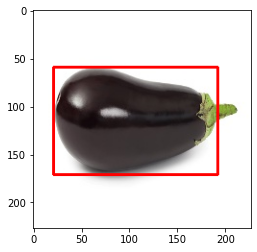

In [7]:
row = df.iloc[184]
img = cv2.imread(DATA_DIR + row.img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
pt1 = (row.xmin, row.ymin)
pt2 = (row.xmax, row.ymax)
bnd_box_img = cv2.rectangle(img, pt1, pt2, (255,0,0), 2)
plt.imshow(img)

In [8]:
train_df, valid_df = train_test_split(df, test_size=0.20, random_state=42)

# Augmentations

In [9]:
import albumentations as A

In [10]:
train_augs = A.Compose([
                A.Resize(IMG_SIZE, IMG_SIZE),
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.5),
                A.Rotate()
], bbox_params=A.BboxParams(format = 'pascal_voc', label_fields = ['class_labels']))

valid_augs = A.Compose([
                A.Resize(IMG_SIZE, IMG_SIZE),
], bbox_params=A.BboxParams(format = 'pascal_voc', label_fields = ['class_labels']))

# Create Custom Dataset

In [11]:
class ObjLocDataset(torch.utils.data.Dataset):

  def __init__(self,df,augmentations):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self,idx):

    row = self.df.iloc[idx]

    xmin = row.xmin
    ymin = row.ymin
    xmax = row.xmax
    ymax = row.ymax

    bbox = [[xmin, ymin, xmax, ymax]] # Albumentation use this format

    img_path = DATA_DIR + row.img_path

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    if self.augmentations:
      data = self.augmentations(image = img,bboxes = bbox, class_labels = [None]) # only localize => don't need class_labels
      img = data['image']
      bbox = data['bboxes'][0]  # get from format: [[xmin, ymin, xmax, ymax]]

    img = torch.from_numpy(img).permute(2,0,1) / 255.0  # torch use (channel, height, weight) => shift channel-axis to 0-axis. So (h,w,c)->(c,h,w)
    bbox = torch.Tensor(bbox)

    return img,bbox

In [12]:
trainset = ObjLocDataset(train_df,train_augs)
validset = ObjLocDataset(valid_df,valid_augs)

In [13]:
print(f"Total examples in the trainset: {len(trainset)}")
print(f"Total examples in the validset: {len(validset)}")


Total examples in the trainset: 148
Total examples in the validset: 38


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


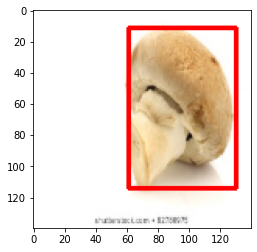

In [14]:
img, bbox = trainset[100]

xmin, ymin, xmax, ymax = bbox

pt1 = (int(xmin), int(ymin))
pt2 = (int(xmax), int(ymax))

bnd_img = cv2.rectangle(img.permute(1, 2, 0).numpy(), pt1, pt2, (255,0,0), 2)  # cv2 use np instead of tensor
plt.imshow(bnd_img)

# Load dataset into batches

In [15]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader = torch.utils.data.DataLoader(validset, batch_size=BATCH_SIZE, shuffle=False)

In [16]:
print("Total no. batches in trainloader : {}".format(len(trainloader)))
print("Total no. batches in validloader : {}".format(len(validloader)))

Total no. batches in trainloader : 10
Total no. batches in validloader : 3


In [17]:
for images,bboxes in trainloader:
  break;

print("Shape of one batch images : {}".format(images.shape))
print("Shape of one batch bboxes : {}".format(bboxes.shape))

Shape of one batch images : torch.Size([16, 3, 140, 140])
Shape of one batch bboxes : torch.Size([16, 4])


# Create Model

In [18]:
from torch import nn 
import timm

In [19]:
timm.list_models('*efficient*')

['efficientnet_b0',
 'efficientnet_b1',
 'efficientnet_b1_pruned',
 'efficientnet_b2',
 'efficientnet_b2_pruned',
 'efficientnet_b2a',
 'efficientnet_b3',
 'efficientnet_b3_pruned',
 'efficientnet_b3a',
 'efficientnet_b4',
 'efficientnet_b5',
 'efficientnet_b6',
 'efficientnet_b7',
 'efficientnet_b8',
 'efficientnet_cc_b0_4e',
 'efficientnet_cc_b0_8e',
 'efficientnet_cc_b1_8e',
 'efficientnet_el',
 'efficientnet_el_pruned',
 'efficientnet_em',
 'efficientnet_es',
 'efficientnet_es_pruned',
 'efficientnet_l2',
 'efficientnet_lite0',
 'efficientnet_lite1',
 'efficientnet_lite2',
 'efficientnet_lite3',
 'efficientnet_lite4',
 'efficientnetv2_l',
 'efficientnetv2_m',
 'efficientnetv2_rw_m',
 'efficientnetv2_rw_s',
 'efficientnetv2_rw_t',
 'efficientnetv2_s',
 'efficientnetv2_xl',
 'gc_efficientnetv2_rw_t',
 'tf_efficientnet_b0',
 'tf_efficientnet_b0_ap',
 'tf_efficientnet_b0_ns',
 'tf_efficientnet_b1',
 'tf_efficientnet_b1_ap',
 'tf_efficientnet_b1_ns',
 'tf_efficientnet_b2',
 'tf_efficien

In [20]:
class ObjLocModel(nn.Module):

  def __init__(self):
    super(ObjLocModel,self).__init__()
    self.backbone = timm.create_model(MODEL_NAME, pretrained=True, num_classes=4)  # output w/o softmax ???

  def forward(self, images, gt_bboxes=None):
    bboxes = self.backbone(images)

    if gt_bboxes != None:
      loss = nn.MSELoss()(bboxes, gt_bboxes)
      return bboxes,loss
    
    return bboxes

In [21]:
model = ObjLocModel()
model.to(DEVICE)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b0_ra-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_ra-3dd342df.pth


ObjLocModel(
  (backbone): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): SiLU(inplace=True)
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act1): SiLU(inplace=True)
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=T

In [22]:
random_img = torch.rand(1, 3, 140, 140).to(DEVICE)  # batch, channel, height, width
model(random_img).shape

torch.Size([1, 4])

# Create Train and Eval Function

In [23]:
def train_fn(model,dataloader,optimizer):
  total_loss = 0.0
  model.train() # train model -> Dropout ON
  
  # tqdm to track batch
  for data in tqdm(dataloader):
    img,gt_bboxes = data  # gt_bboxes = ground truth
    img,gt_bboxes = img.to(DEVICE),gt_bboxes.to(DEVICE)
    bboxes, loss = model(img, gt_bboxes)  # model predict

    # gradient steps
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
  
  return total_loss / len(dataloader)

In [24]:
def valid_fn(model,dataloader):
  total_loss = 0.0
  model.eval() # evaluate model -> Dropout OFF

  with torch.no_grad():
    for data in tqdm(dataloader): # tqdm to track batch
      img, gt_bboxes = data
      img, gt_bboxes = img.to(DEVICE), gt_bboxes.to(DEVICE)
      
      bboxes, loss = model(img, gt_bboxes)
      total_loss += loss.item()
    
    return total_loss / len(dataloader) # avg loss

#Training Loop

In [25]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [26]:
best_valid_loss = np.Inf

for i in range(EPOCHS):
  train_loss = train_fn(model, trainloader, optimizer)
  valid_loss = valid_fn(model, validloader)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    print("Weights are saved")
    best_valid_loss = valid_loss

  print(f"Epoch : {i+1} train loss: {train_loss} valid loss: {valid_loss}")

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved
Epoch : 1 train loss: 5346.417041015625 valid loss: 3087.34619140625


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved
Epoch : 2 train loss: 2041.0482177734375 valid loss: 1344.2972005208333


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved
Epoch : 3 train loss: 1116.477001953125 valid loss: 189.24149068196616


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 4 train loss: 757.5976043701172 valid loss: 233.6969197591146


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved
Epoch : 5 train loss: 520.025277709961 valid loss: 122.15709686279297


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 6 train loss: 404.08863677978513 valid loss: 167.47137451171875


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 7 train loss: 301.43846435546874 valid loss: 216.7215576171875


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 8 train loss: 225.6427230834961 valid loss: 128.66197204589844


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 9 train loss: 212.88994293212892 valid loss: 159.9911651611328


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 10 train loss: 148.08547439575196 valid loss: 176.84059143066406


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 11 train loss: 127.05998458862305 valid loss: 174.77284240722656


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved
Epoch : 12 train loss: 116.21394958496094 valid loss: 103.35093180338542


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved
Epoch : 13 train loss: 98.93907165527344 valid loss: 90.55324808756511


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 14 train loss: 106.79923934936524 valid loss: 98.9955546061198


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 15 train loss: 117.41066665649414 valid loss: 109.58866628011067


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 16 train loss: 85.16662406921387 valid loss: 132.93255106608072


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 17 train loss: 80.44855575561523 valid loss: 111.62776692708333


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved
Epoch : 18 train loss: 63.23706245422363 valid loss: 67.15708414713542


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 19 train loss: 64.34098167419434 valid loss: 89.79197184244792


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 20 train loss: 76.57526206970215 valid loss: 124.94425201416016


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved
Epoch : 21 train loss: 60.73062591552734 valid loss: 58.74852625528971


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 22 train loss: 50.43277549743652 valid loss: 63.942160288492836


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 23 train loss: 50.74723854064941 valid loss: 70.43226114908855


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 24 train loss: 55.54638786315918 valid loss: 60.393419901529946


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 25 train loss: 55.521949005126956 valid loss: 62.18671798706055


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 26 train loss: 40.41487865447998 valid loss: 82.04082361857097


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 27 train loss: 48.88953857421875 valid loss: 60.991441090901695


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 28 train loss: 54.990412902832034 valid loss: 71.655091603597


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 29 train loss: 49.25725383758545 valid loss: 66.10562133789062


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 30 train loss: 54.304161071777344 valid loss: 76.18737665812175


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 31 train loss: 44.67984237670898 valid loss: 59.601542154947914


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 32 train loss: 42.246143913269044 valid loss: 73.89024098714192


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved
Epoch : 33 train loss: 50.6095911026001 valid loss: 48.04311879475912


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 34 train loss: 40.44996509552002 valid loss: 53.3603146870931


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 35 train loss: 53.54887771606445 valid loss: 55.82291793823242


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 36 train loss: 40.614616584777835 valid loss: 76.05801264444987


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 37 train loss: 55.823937225341794 valid loss: 70.71621449788411


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 38 train loss: 49.606952857971194 valid loss: 80.41058731079102


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 39 train loss: 45.692118644714355 valid loss: 64.7334721883138


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 40 train loss: 46.85626754760742 valid loss: 64.1241086324056


#Inference

In [27]:
import utils  # from /content/object-localization-dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


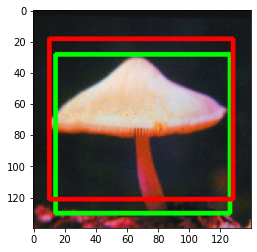

In [29]:
model.load_state_dict(torch.load('best_model.pt'))

with torch.no_grad():
  image, gt_box = validset[5] # (c,h,w)
  image = image.unsqueeze(0).to(DEVICE) # (batch-size, c, h, w)
  out_bbox = model(image)

  utils.compare_plots(image, gt_box, out_bbox)

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya